# **Loading Libraries**

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm  # Doğru şekilde tqdm modülünü çağırın
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.applications.efficientnet import EfficientNetB0
from sklearn.metrics import confusion_matrix
import itertools

**Global Variables**

In [24]:
labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
xtrain = []
ytrain = []
xtest = []
ytest = []
img_size = 150
batch_size = 32
epochs = 12
path = "/content/drive/MyDrive/Colab Notebooks/tumor_imgs"

# **Functions**

In [42]:
def procces_data(x,y,img_size,labels):
    for label in labels:
        folderPath = os.path.join(path, "Training", label)
        print(label)
        for file_name in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath, file_name))
            img = cv2.resize(img, (img_size, img_size))

            x.append(img)
            y.append(label)

    x = np.array(x)
    y = np.array(y)
    return x,y

def show_random_images(x, y, value=3):
    plt.figure(figsize=(10, 5))
    # num = random.randint(0, len(x))
    num = 0
    for i in range(num, num+value):
        plt.subplot(int(value/3), 3, i-num+1)
        plt.imshow(x[i])
        plt.title(y[i])
        plt.axis("off")
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(14,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)

    thresh = cm.max() / 1.1 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=8)
        else:
            plt.text(j, i, "{}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=8)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()


# **Processing Data**

In [26]:
xtrain, ytrain = procces_data(xtrain, ytrain, img_size, labels)
xtest, ytest = procces_data(xtest, ytest, img_size, labels)

glioma_tumor


100%|██████████| 826/826 [00:12<00:00, 63.84it/s]


meningioma_tumor


100%|██████████| 822/822 [00:12<00:00, 64.32it/s]


no_tumor


100%|██████████| 395/395 [00:05<00:00, 75.09it/s]


pituitary_tumor


100%|██████████| 827/827 [00:14<00:00, 58.29it/s]


glioma_tumor


100%|██████████| 826/826 [00:08<00:00, 95.34it/s]


meningioma_tumor


100%|██████████| 822/822 [00:08<00:00, 93.61it/s]


no_tumor


100%|██████████| 395/395 [00:03<00:00, 112.71it/s]


pituitary_tumor


100%|██████████| 827/827 [00:09<00:00, 89.64it/s]


In [27]:
xtrain.shape

(2870, 150, 150, 3)

**Shuffle data**

In [28]:
xtrain, ytrain = shuffle(xtrain, ytrain)

Random 6 image from xtrain and ytrain for test the model.


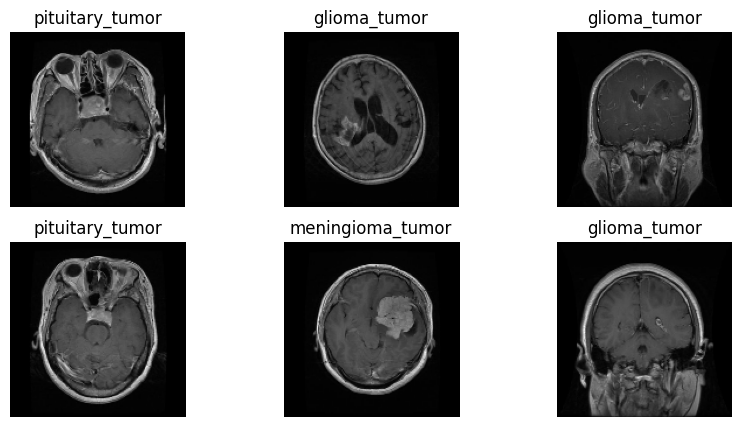

In [29]:
show_random_images(xtrain, ytrain, 6)

**Encoding**

In [30]:
ytrain_new = []
for i in ytrain:
    ytrain_new.append(labels.index(i))
ytrain = ytrain_new
ytrain = to_categorical(ytrain)


ytest_new = []
for i in ytest:
    ytest_new.append(labels.index(i))
y_test = ytest_new
y_test = to_categorical(y_test)

# **EffNetB0**
Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the EfficientNetB0 model which will use the weights from the ImageNet dataset.

The include_top parameter is set to False so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!


In [ ]:
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size,img_size,3))
model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(rate=0.5)(model)
model = Dense(4 ,activation='softmax')(model)
model = Model(inputs=effnet.input, outputs=model)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto', verbose=1)
checkpoint = ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/checkpoints/best_model.h5", save_best_only=True)

# **Training The Model**

In [ ]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=[reduce_lr, checkpoint])

Epoch 1/12
81/81 [==============================] - ETA: 0s - loss: 0.4202 - accuracy: 0.8467

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 51s 237ms/step - loss: 0.4202 - accuracy: 0.8467 - val_loss: 0.6081 - val_accuracy: 0.8258 - lr: 0.0010
Epoch 2/12
81/81 [==============================] - 13s 156ms/step - loss: 0.1660 - accuracy: 0.9462 - val_loss: 0.2914 - val_accuracy: 0.9164 - lr: 0.0010
Epoch 3/12
81/81 [==============================] - 12s 151ms/step - loss: 0.1085 - accuracy: 0.9586 - val_loss: 0.2815 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 4/12
81/81 [==============================] - 12s 152ms/step - loss: 0.0662 - accuracy: 0.9779 - val_loss: 0.1964 - val_accuracy: 0.9582 - lr: 0.0010
Epoch 5/12
81/81 [==============================] - 13s 163ms/step - loss: 0.0522 - accuracy: 0.9803 - val_loss: 0.1314 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 6/12
81/81 [==============================] - 11s 141ms/step - loss: 0.0522 - accuracy: 0.9868 - val_loss: 0.1620 - val_accuracy: 0.9373 - lr: 0.0010
Epoch 7/12
81/81 [==============================] - ETA: 0s - loss: 0.0719 

# **Evaluate The Model**

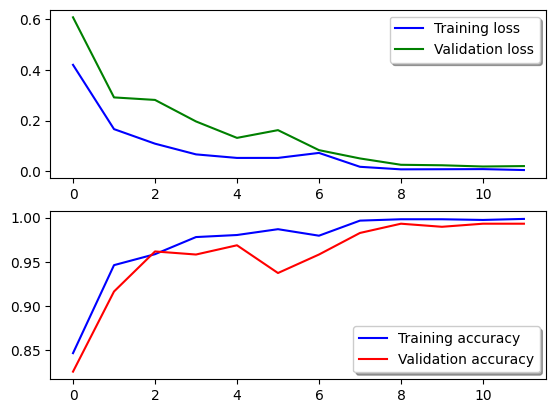

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history["loss"], color="b", label="Training loss")
ax[0].plot(history.history["val_loss"], color="g", label="Validation loss")
legend = ax[0].legend(loc="best", shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

**Predict the values from the validation dataset**

In [31]:
from keras.models import load_model
best_model = load_model("/content/drive/MyDrive/Colab Notebooks/checkpoints/best_model.h5")

In [32]:
Y_pred = best_model.predict(xtest)

90/90 [==============================] - 81s 869ms/step


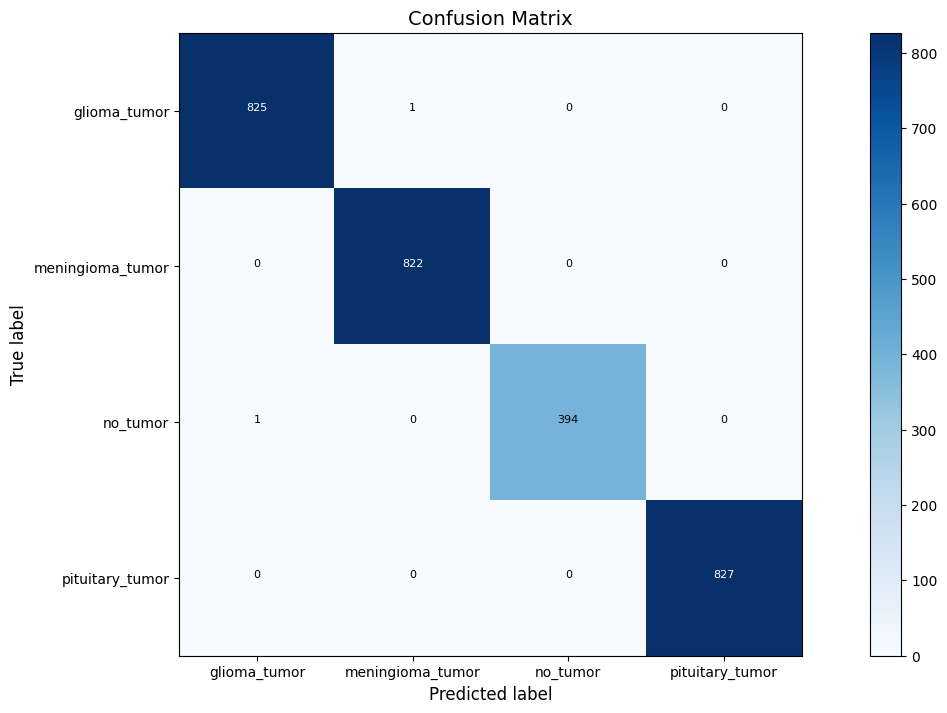

In [43]:
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1) # Find the index of the maximum value

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = labels)